In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve, auc
import multiprocessing as mp
base_dir = f'/mnt/lustre/koa/class/atmo449_class/students/team_1_flood_risk/'

In [2]:
import numpy as np

def corr_timeseries(A, B):
    """
    Compute time-varying correlation between two arrays A and B
    of shape (time, lat, lon), returning a 1D array (time,).

    The correlation at each timestep is computed by flattening
    the 2D fields and computing Pearson correlation.
    """
    # reshape to (time, pixels)
    A2 = A.reshape(A.shape[0], -1)
    B2 = B.reshape(B.shape[0], -1)

    # subtract mean along pixels
    A2c = A2 - A2.mean(axis=1, keepdims=True)
    B2c = B2 - B2.mean(axis=1, keepdims=True)

    # numerator of Pearson r
    num = np.sum(A2c * B2c, axis=1)

    # denominator
    den = np.sqrt(np.sum(A2c**2, axis=1) * np.sum(B2c**2, axis=1))

    # avoid division by zero
    corr = num / den
    corr[den == 0] = np.nan

    return corr


# Load Streamflow Gauge Readings

In [3]:
station_id = 16240500# manoa
df_obs = pd.read_csv(f"{base_dir}/preprocessed_data/selected_flowgauge_15mins/{station_id}.csv")
df_obs['hst_timestamp'] = pd.to_datetime(df_obs['hst_timestamp'])
df_obs['utc_timestamp'] = df_obs['hst_timestamp'].dt.tz_convert('UTC')
df_obs = df_obs.set_index('utc_timestamp').drop(columns=['hst_timestamp'])
df_obs.index = df_obs.index.tz_localize(None)

In [4]:
df_obs_hourly_mean_all = df_obs.resample('h').mean()
df_obs_hourly_mean = df_obs_hourly_mean_all[(df_obs.groupby(pd.Grouper(freq='h')).size() == 4)]
df_3hourly = df_obs_hourly_mean.resample('3h').max()

threshold = 3
num_exceedance = sum(df_3hourly['measurement'] > 3)
print(f"With {threshold=}, there are {num_exceedance} occurences of \"flood\"")
df_obs = df_3hourly # rename for easy typing

With threshold=3, there are 14 occurences of "flood"


# Load ERA5

In [5]:
all_year_data = []
for year in tqdm(range(2007, 2025)):
    all_year_data.append(xr.open_dataset(f"{base_dir}/preprocessed_data/regridded_3hourly_ERA5/{year}.nc"))
concatenated = xr.concat(all_year_data, dim='time').sel(lon=slice(195, 210), lat=slice(15, 26))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.34it/s]


In [6]:
concatenated['pr'] = concatenated['tp'] * 1000 * 24# m/hour to mm/day. For consistency with CMIP

In [7]:
extreme_weathers = (concatenated.drop_duplicates(dim='time')
                    .sel(time=df_obs.query(f'measurement >= {threshold}').index))

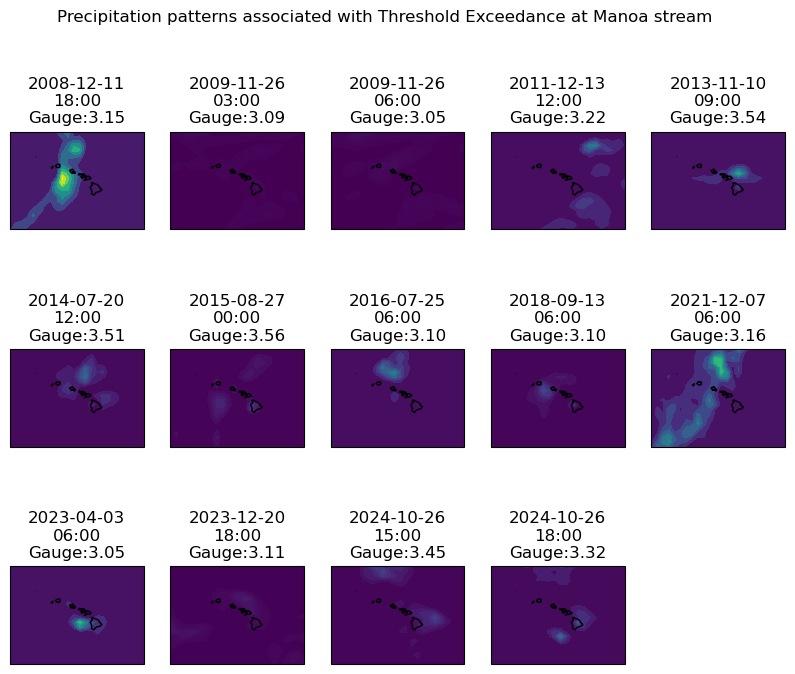

In [8]:
lons, lats = np.meshgrid(extreme_weathers.lon, extreme_weathers.lat)
fig, axs = plt.subplots(3,5, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(10,8))
vmin, vmax = extreme_weathers['pr'].min(), extreme_weathers['pr'].max()
fig.delaxes(axs[2,4])
for i, ax in enumerate(axs.flatten()[:-1]):
    individual_weather = extreme_weathers.isel(time=i) # xarray
    gauge = df_obs[df_obs.index == pd.Timestamp(individual_weather.time.values)]['measurement'].values[0] # pandas
    ax.contourf(lons, lats, individual_weather['pr'], vmin=vmin, vmax=vmax)
    ax.coastlines()
    ax.set_title(pd.Timestamp(individual_weather.time.values).strftime("%Y-%m-%d\n%H:%M") + f"\nGauge:{gauge:.2f}")

fig.suptitle('Precipitation patterns associated with Threshold Exceedance at Manoa stream')
pass

In [9]:
dry_months, wet_months = [5,6,7,8,9,10], [1,2,3,4,11,12]
wet_composite = extreme_weathers.sel(time=extreme_weathers['time'].dt.month.isin(wet_months))['pr'].mean(axis=0)
dry_composite = extreme_weathers.sel(time=extreme_weathers['time'].dt.month.isin(dry_months))['pr'].mean(axis=0)

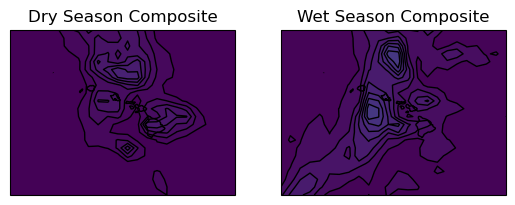

In [10]:
fig, axs = plt.subplots(1,2, subplot_kw=dict(projection=ccrs.PlateCarree()))
for ax, composite in zip(axs.flatten(), [dry_composite, wet_composite]):
    ax.contourf(lons, lats, composite, vmin=vmin, vmax=vmax)
    ax.coastlines()
    cs = ax.contour(lons, lats, composite, colors='k', linewidths=1, transform=ccrs.PlateCarree())
    # add contour labels
    # lb = plt.clabel(cs, fontsize=12, inline=False, fmt='%0.1f');
axs[0].set_title('Dry Season Composite')
axs[1].set_title('Wet Season Composite')
pass

In [11]:
seasonal_composite_ts = np.stack([dry_composite.to_numpy() if (t.month in dry_months) else wet_composite.to_numpy() for t in pd.to_datetime(concatenated.time)])
coors = corr_timeseries(concatenated['pr'].to_numpy(), seasonal_composite_ts)

df_stats = pd.DataFrame({'ts': concatenated.time, 'r': coors})
df_stats = pd.merge(df_obs, df_stats, left_index=True, right_on='ts')
df_stats['exceed'] = df_stats['measurement'] > 3

fpr, tpr, thresholds = roc_curve(df_stats.dropna()['exceed'], np.clip(df_stats.dropna()['r'], a_min=0, a_max=None))
roc_auc = auc(fpr, tpr)

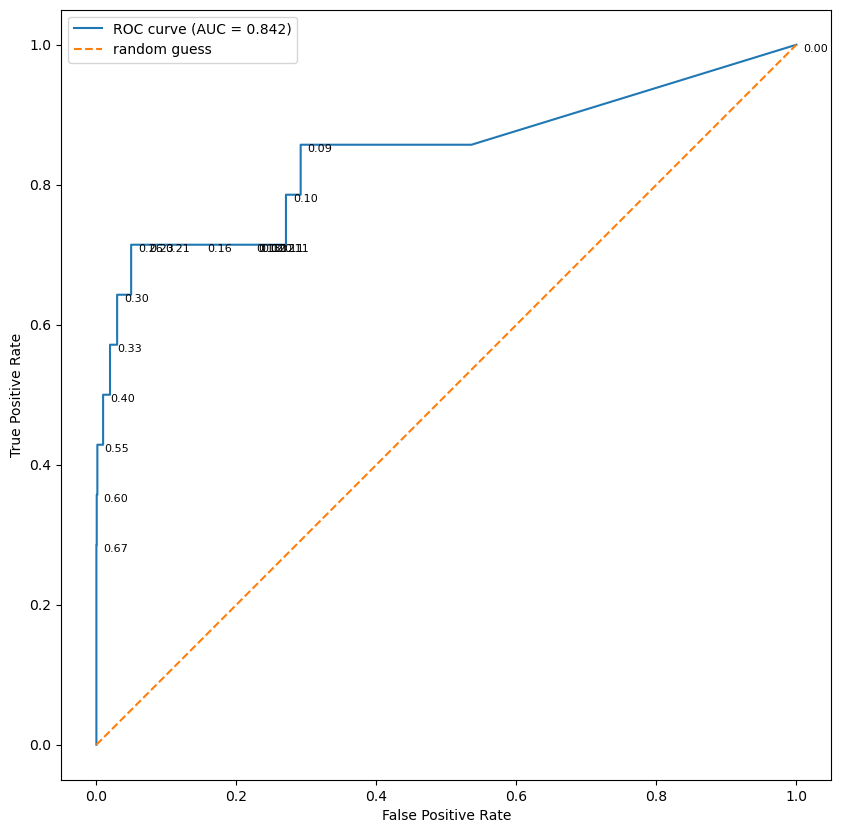

In [12]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot([0,1], [0,1], linestyle='--', label='random guess')
ax.legend()

# Annotate thresholds (skip first threshold; it's always > max score)
for fp, tp, thr in zip(fpr[2::2], tpr[2::2], thresholds[2::2]):
    ax.annotate(
        f"{thr:.2f}",
        xy=(fp, tp),
        textcoords="offset points",
        xytext=(5, -5),
        fontsize=8,
        color='black'
    )

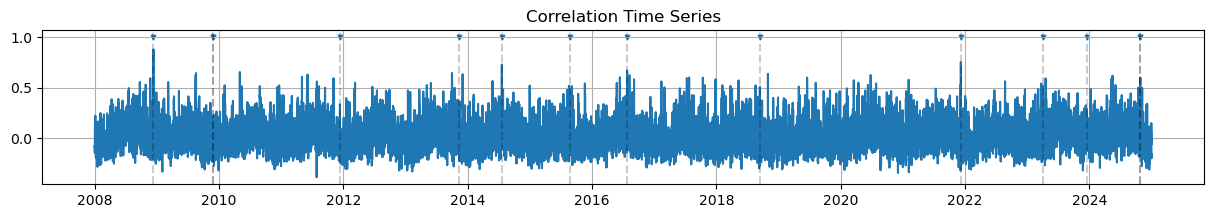

In [13]:
fig, ax = plt.subplots(1, figsize=(15,2))
ax.plot(df_stats['ts'], df_stats['r'])
ax.scatter(df_obs.query('measurement > 3').index, [1 for _ in range(len(df_obs.query('measurement > 3').index))], s=10, marker='v')
for i in df_obs.query('measurement > 3').index:
    ax.axvline(i, linestyle='--', c='k', alpha=0.2)
# ax.axhline(0.6, linestyle='--', c='orange')
ax.set_title('Correlation Time Series')
ax.grid()

In [18]:
df_stats.query('exceed == True')

,measurement,ts,r,exceed
5686,3.146250,2008-12-11 18:00:00,0.879538,True
8481,3.087500,2009-11-26 03:00:00,-0.036086,True
8482,3.047500,2009-11-26 06:00:00,0.092459,True
14460,3.223333,2011-12-13 12:00:00,-0.118502,True
20043,3.539167,2013-11-10 09:00:00,0.255311,True
22060,3.511667,2014-07-20 12:00:00,0.729094,True
25280,3.562083,2015-08-27 00:00:00,0.297381,True
27946,3.096667,2016-07-25 06:00:00,0.671964,True
34186,3.098333,2018-09-13 06:00:00,0.397409,True
43634,3.164167,2021-12-07 06:00:00,0.753698,True


In [16]:
(df_stats['r'] > 0.5).sum()

137

In [14]:
(df_stats['r'] > 0.5).sum()/ df_stats.shape[0]

0.002758037565679544

# Run this on historical ERA5

In [132]:
all_year_data = []
for year in tqdm(range(1981, 2011)):
    all_year_data.append(xr.open_dataset(f"{base_dir}/preprocessed_data/regridded_3hourly_ERA5/{year}.nc"))
concatenated = xr.concat(all_year_data, dim='time').sel(lon=slice(195, 210), lat=slice(15, 26))

 13%|████████████████████████▋                                                                                                                                                                | 4/30 [00:00<00:00, 34.36it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.13it/s]


In [135]:
concatenated['pr'] = concatenated['tp'] * 1000 * 24

In [134]:
seasonal_composite_ts = np.stack([dry_composite.to_numpy() if (t.month in dry_months) else wet_composite.to_numpy() for t in pd.date_range('1981-01-01 00:00', '2010-12-31-21:00', freq='3h')])

In [137]:
coors = corr_timeseries(concatenated['pr'].to_numpy(), seasonal_composite_ts)
df_stats_era5_historical = pd.DataFrame({'ts': pd.date_range('1981-01-01 00:00', '2010-12-31-21:00', freq='3h'), 'r': coors})

In [141]:
sum(df_stats_era5_historical['r'] > 0.5)

215

# Run this on historical CMIP

In [163]:
# historical
ds_gcm_historical = xr.open_dataset(f"{base_dir}/wasfia/GFDL_CM4C192_pr_hawaii_1981_2010.nc").sel(lon=slice(195, 210), lat=slice(15, 26))
seasonal_composite_ts = np.stack([dry_composite.to_numpy() if (t.month in dry_months) else wet_composite.to_numpy() for t in pd.date_range('1981-01-01 00:00', '2010-12-31-21:00', freq='3h')])
coors = corr_timeseries(ds_gcm_historical['pr'].to_numpy(), seasonal_composite_ts)
df_stats_gcm_historical = pd.DataFrame({'ts': pd.date_range('1981-01-01 00:00', '2010-12-31-21:00', freq='3h'), 'r': coors})

In [171]:
df_stats_gcm_historical.shape

(87656, 2)

In [173]:
sum(df_stats_gcm_historical['r'] > 0.5), "over", df_stats_gcm_historical.shape[0]

(385, 'over', 87656)

In [164]:
# future
ds_gcm_future = xr.open_dataset(f"{base_dir}/wasfia/GFDL_CM4C192_pr_hawaii_future_2015_2050.nc").sel(lon=slice(195, 210), lat=slice(15, 26))
seasonal_composite_ts = np.stack([dry_composite.to_numpy() if (t.month in dry_months) else wet_composite.to_numpy() for t in pd.date_range('2015-01-01 00:00', '2050-12-31-21:00', freq='3h')])
coors = corr_timeseries(ds_gcm_future['pr'].to_numpy(), seasonal_composite_ts)
df_stats_gcm_future = pd.DataFrame({'ts': pd.date_range('2015-01-01 00:00', '2050-12-31-21:00', freq='3h'), 'r': coors})

/tmp/ipykernel_2255458/2543235321.py:26: RuntimeWarning: invalid value encountered in divide
  corr = num / den


In [174]:
sum(df_stats_gcm_future['r'] > 0.5), 'over', df_stats_gcm_future.shape[0]

(323, 'over', 105192)

0.878514315976052
0.7958522500819166


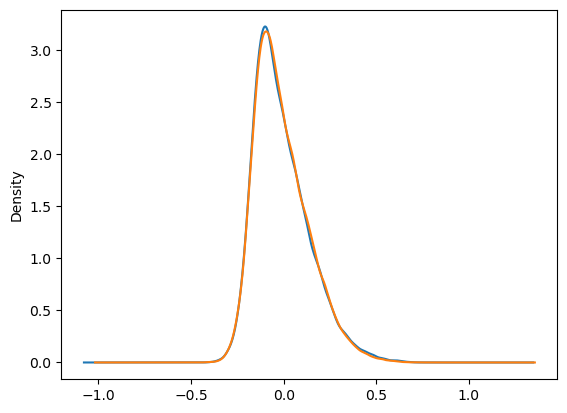

In [183]:
df_stats_gcm_historical['r'].plot.kde()
df_stats_gcm_future['r'].plot.kde()
print(df_stats_gcm_historical['r'].skew())
print(df_stats_gcm_future['r'].skew())
pass

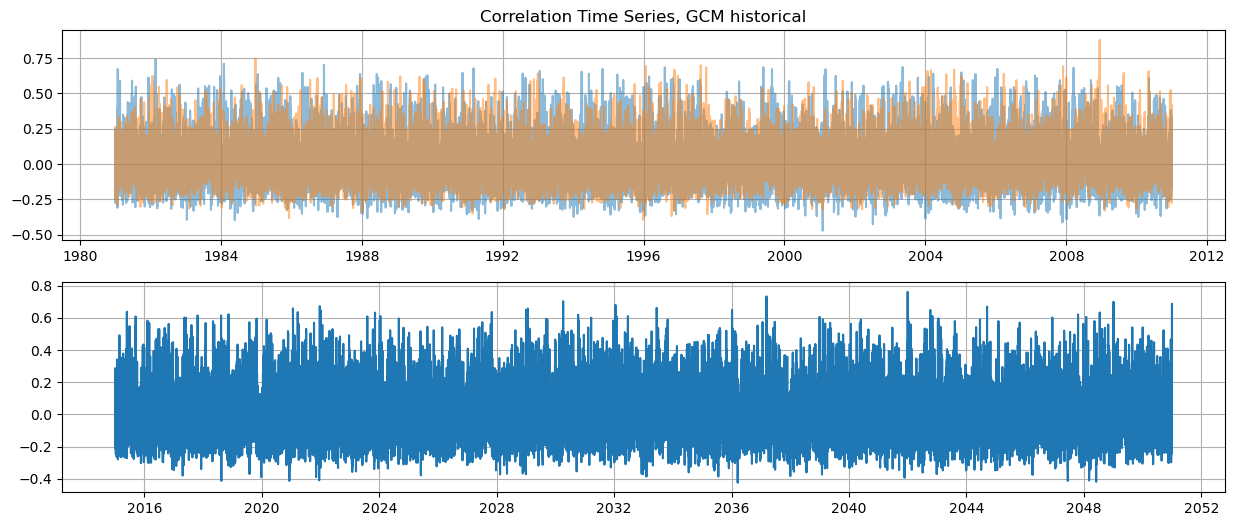

In [168]:
fig, axs = plt.subplots(2, 1, figsize=(15,6))
axs[0].plot(df_stats_gcm_historical['ts'], df_stats_gcm_historical['r'], alpha=0.5)
axs[0].plot(df_stats_era5_historical['ts'], df_stats_era5_historical['r'], alpha=0.5)
axs[0].set_title('Correlation Time Series, GCM historical')
axs[0].grid()

axs[1].plot(df_stats_gcm_future['ts'], df_stats_gcm_future['r'])
axs[1].grid()